In [14]:
from pymongo import MongoClient
from pytz import timezone
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from nltk import PorterStemmer
import re
from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy.sparse import csr_matrix
from sklearn import svm 
from sklearn.utils import shuffle
import age_gender_predictor
from random import randint
from sklearn.cross_validation import StratifiedShuffleSplit
from copy import copy
import pandas as pd
from Levenshtein import *
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler
import json
%matplotlib inline



In [111]:
def load_stopwords(file_location="../SmartStoplist"):
    f = open(file_location)
    stopwords = [line.strip() for line in f]
    return stopwords + ["http","https", "don", "thi","http ", "co","dont","im"]

stopwords = load_stopwords()
stemmer = PorterStemmer()
stopSet = set(stopwords)

def preprocessor(text):
    stemmer = PorterStemmer()
    words = []
    global stopSet
    
    for word in text.lower().split():
        word = re.sub('[!@#$?\'\"]|&amp', '',word)
        stemmedWord = stemmer.stem_word(word)
        condition_Word = word not in stopSet  and "http" not in word
        condition_StemmedWord = stemmedWord not in stopSet
        
        if  condition_Word and  condition_StemmedWord:
            words.append(stemmedWord)
    return " ".join(words)

def loads_LIWC():
    f = open("categories.json", 'r')
    categories = json.load(f)
    f = open("words.json", 'r')
    words = json.load(f)
    patterns_categories = {}
    for word, category in words.items():
        if word[-1] == '*':
            current_dict = patterns_categories
            for char in word:
                if char == '*':
                   
                    #current_dict = category
                    pre_dict[word[-2]] = category
                    break
                
                elif char not in current_dict:
                    current_dict[char] = {}
                pre_dict = current_dict
                current_dict = current_dict[char]
                
    return categories, words, patterns_categories
LIWC_categories, LIWC_words, LIWC_patterns_categories = loads_LIWC() 

In [112]:
#Feature Extraction Functions
 





def getTFIDF(usersDataList):
    textsList = []
    for usersData in usersDataList:
        texts = ""
        for data in usersData.values():
            for text in data["texts"]:
                texts += preprocessor(text) + "\n"
        textsList.append(texts)
 
    tfidf = TfidfVectorizer(stop_words="english",ngram_range = (1,2))
    tfidf.fit(textsList)
    return tfidf




 
        

    
def getEmotionFeature(usersDataList):
    
    emotions = ['surprise', 'fear', 'sadness', 'disgust', 'trust', 'anticipation', 'anger','joy']
    featuresList = []

    
    for usersData in usersDataList:
        features = []
        for data in usersData.values():
            feature = np.array([])
            emotionCompositions = np.zeros(len(emotions),dtype=float)
            for i, emotion in enumerate(emotions):
                feature = np.concatenate((feature, (data["emotions"].get(emotion, emptyHourTable()))))
                emotionCompositions[i] = np.sum(data["emotions"].get(emotion, emptyHourTable()))
            feature = np.concatenate((feature,emotionCompositions))
            features.append(feature)
            
        featuresList.append(np.array(features))
        
    return featuresList



def getTextFeature(usersDataList, text_model):
    if text_model == "tfidf":
       model = TfidfVectorizer(stop_words="english",ngram_range = (1,2))
    
    getText = lambda data : "\n".join(data["texts"])
    usersTextsList = []
    totalTexts = []
    for usersData in usersDataList:
        usersTexts = []
        for data in usersData.values():
            text = getText(data)
            totalTexts.append(text)
            usersTexts.append(text)
        usersTextsList.append(usersTexts)
    model.fit(totalTexts)
    
    featuresList = []
    for usersTexts in usersTextsList:
        featuresList.append(model.transform(usersTexts))
        
    return featuresList, model

def featureCombination(emotion_features, text_features):
    featuresList = []
    for i in range(len(emotion_features)):
        new_features = csr_matrix(hstack((emotion_features[i], text_features[i])))
        
        featuresList.append(new_features)
    return featuresList
    

    
def featureExtraction(usersDataList, emotion_extraction=True, text_extraction=True, text_model="tfidf"):
    
    featuresList = []
 
    
    if emotion_extraction:
        emotion_features = getEmotionFeature(usersDataList)
        
        if not text_extraction:
            featuresList = emotion_features
        
        
    if text_extraction:
        
        text_features, model = getTextFeature(usersDataList, text_model)
        
        
        if emotion_extraction:
            featuresList = featureCombination(emotion_features, text_features)
        else:
            featuresList = text_features
        
    Ylist = []
    for label, usersData in enumerate(usersDataList):
        Y = np.zeros(len(usersData),dtype=int)
        Y[:] = label
        Ylist.append(Y)
        
    if text_extraction:
        return list(zip(featuresList, Ylist)), model 
    else:
        return list(zip(featuresList, Ylist)) 
    
    
  

In [113]:
def XYGenerator(featuresList,verbose=True):
    X, Y = featuresList[0]
    

    
    for x, y in featuresList[1:]:
        try:
            
            X = np.concatenate((X, x))
        except:
            X = vstack([X, x])
            
        Y = np.concatenate((Y, y))
    
   
    
    
    return X, Y

In [114]:
def showImportantFeatures(features_importance, text_model, n_features = 10):
    
    if text_model is None:
        print("The top {} most important features:\n".format(n_features))
        emotions = ['surprise', 'fear', 'sadness', 'disgust', 'trust', 'anticipation', 'anger','joy']
        for vector in features_importance[:n_features]:
            
            if vector >= 192:
                
                emotion = emotions[vector - 192]
                print("The {} ratio of users".format(emotion))
            
            else:
                emotion = emotions[int(vector/24)]
                hour = vector % 24
                print("The daily {} ratio at {} o'clock".format(emotion, hour))
        
        
        
    else:
        print("The following are the top {} most important features:\n".format(n_features))
        vector2word = text_model.get_feature_names()
        for vector in features_importance[:n_features]:
            word = vector2word[vector]
            print(word)


In [137]:
#plotting functions
def plot_precision_recall(classifier, featuresList, n_fold=20):
    
    
    
    SCORES = np.array([])
    LABELS = np.array([])
    
    X, Y = XYGenerator(featuresList)

  

    
    sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )

    
    for train_index, test_index in sss:
      
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        classifier.fit(X_train, Y_train)
        score = classifier.predict_proba(X_test)[:,1]
        SCORES = np.concatenate((SCORES, score))
        LABELS = np.concatenate((LABELS, Y_test))
        
        
    precision, recall, _ = precision_recall_curve(LABELS, SCORES, pos_label=1)
    average_precision = average_precision_score(LABELS, SCORES)
      
    
    
    
    
    
    BPD_train = np.count_nonzero(Y_train)
    BPD_test = np.count_nonzero(Y_test)
    normal_train = Y_train.shape[0] - BPD_train
    normal_test = Y_test.shape[0] - BPD_test
    
    print("{} Normal and {} BPD in Training Data".format(normal_train,BPD_train))
    print("{} Normal and {} BPD in Test Data".format(normal_test,BPD_test))
 
    
    fig, ax = plt.subplots()
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.title.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.xaxis.label.set_color('white')
    
    plt.plot(recall, precision, label='area = %0.2f' %  average_precision , color="green",linewidth=3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="lower right")
    try:
        print("Number of features: {}".format(len(classifier.feature_importances_)))
    except:
        print("Number of features: {}".format(len(classifier.coef_[0])))
    plt.show()
    return classifier
def plot_multiple_precision_recall(classifier, featuresLists,names,colors=['r','g','b',"y","w",'c','o'] , n_fold=30):
    
    

    fig, ax = plt.subplots()
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.title.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.xaxis.label.set_color('white')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    
    for g,featuresList in enumerate(featuresLists):

        SCORES = np.array([])
        LABELS = np.array([])

        X, Y = XYGenerator(featuresList)




        sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )


        for train_index, test_index in sss:

            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y_test))


        precision, recall, _ = precision_recall_curve(LABELS, SCORES, pos_label=1)
        average_precision = average_precision_score(LABELS, SCORES)






        BPD_train = np.count_nonzero(Y_train)
        BPD_test = np.count_nonzero(Y_test)
        normal_train = Y_train.shape[0] - BPD_train
        normal_test = Y_test.shape[0] - BPD_test

       

        plt.plot(recall, precision, label=names[g] , color=colors[g],linewidth=3)
      
        plt.legend(loc="lower right")
        
    print("{} Normal and {} BPD in Training Data".format(normal_train,BPD_train))
    print("{} Normal and {} BPD in Test Data".format(normal_test,BPD_test))

    plt.show()
def plot_ROC(classifier, featuresList, n_fold=20):
      
    SCORES = np.array([])
    LABELS = np.array([])
    
    X, Y = XYGenerator(featuresList)

    
    sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )

    
    for train_index, test_index in sss:
      
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        classifier.fit(X_train, Y_train)
        score = classifier.predict_proba(X_test)[:,1]
        SCORES = np.concatenate((SCORES, score))
        LABELS = np.concatenate((LABELS, Y_test))
        
      
    fpr, tpr, _ = roc_curve(LABELS, SCORES, pos_label=1)
    roc_auc = auc(fpr, tpr)
       
   
    
    
    BPD_train = np.count_nonzero(Y_train)
    BPD_test = np.count_nonzero(Y_test)
    normal_train = Y_train.shape[0] - BPD_train
    normal_test = Y_test.shape[0] - BPD_test
    print("{} Normal and {} BPD in Training Data".format(normal_train,BPD_train))
    print("{} Normal and {} BPD in Test Data".format(normal_test,BPD_test))
    
  
   
 

    fig, ax = plt.subplots()
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.title.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.xaxis.label.set_color('white')
    
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, color="green",linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--', color="w")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    try:
        print("Number of features: {}".format(len(classifier.feature_importances_)))
    except:
        print("Number of features: {}".format(len(classifier.coef_[0])))
    plt.show()
    return classifier


In [116]:
#John Hopkins Patten of lifes:

def thirdPronuonDetect(words, matcher=re.compile("@[a-z]+")):
    for word in words:
        if word == "@":
            continue
        elif matcher.search(word):
            return True
    return False
    
def tweetRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    totla_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    return total_tweets / totla_duration
def mentioRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    total_mentions = np.sum(seriesContains(timeSeries, method="third"))
    return total_mentions / total_tweets

def uniqueMentions(timeSeries):
    total_tweets = timeSeries.shape[0]
    friends_set = set()
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_set.add(word)
    return len(friends_set)

def frequentMentions(timeSeries, lowerbound = 3):
    total_tweets = timeSeries.shape[0]
    friends_mentions = {}
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_mentions[word] = friends_mentions.get(word, 0) +1
    frequent_frients = [screen_name for screen_name, mentions in friends_mentions.items() if mentions >= lowerbound]
    return len(frequent_frients)

def getNegativeRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == -1) / total_tweets


def getPositiveRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == 1) / total_tweets





In [22]:
pd.set_option('display.max_colwidth', 10000)

In [124]:
# new functions

def getAge(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_age(texts)

def getGender(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_gender(texts)
        



def getNegativeCount(timeSeries):
    return np.sum(timeSeries["polarity"].values == -1)


def getUsersPolarities(collectionName):
    collection = MongoClient("localhost", 27017)['idea'][collectionName]
    usersPolarties = {}
    for tweet in collection.find():
        userID = tweet["user"]["id"]
        #Processing emotions from Carlos' API
        emotion =  tweet["emotion"]["groups"][0]["name"]
        if len(tweet["emotion"]["groups"]) > 1:
            emotion_2 = tweet["emotion"]["groups"][1]["name"]
            
        ambiguous = True if tweet['emotion']['ambiguous'] == 'yes' else False
       
        if len(tweet["emotion"]["groups"]) > 1:
            emotion_2 = tweet["emotion"]["groups"][1]["name"]    
        else:
            emotion_2 = None
        if tweet["polarity"] == "positive":
            polarity = 1
        elif tweet["polarity"] == "negative":
            polarity = -1
        else:
            polarity = 0
   
            
        date = tweet["created_at"]
        text = tweet['text']

        if userID not in usersPolarties:
            usersPolarties[userID] = {}
        if date not in usersPolarties[userID]:
            usersPolarties[userID][date] = {}
        usersPolarties[userID][date]['text'] = text
        usersPolarties[userID][date]['polarity'] =  polarity
        usersPolarties[userID][date]['emotion'] =  emotion
        usersPolarties[userID][date]['emotion_2'] =  emotion_2
        usersPolarties[userID][date]['ambiguous'] =  ambiguous
    return usersPolarties


def timeSeriesTransform(usersEmotions):
    for userID in usersEmotions:
        usersEmotions[userID] = pd.DataFrame.from_dict(usersEmotions[userID], orient='index').fillna(0)
        usersEmotions[userID]['dt'] = np.zeros(usersEmotions[userID].shape[0],dtype=float)
        usersEmotions[userID].loc[:-1,'dt'] = (usersEmotions[userID].index[1:].values - usersEmotions[userID].index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return list(usersEmotions.values())



def userVerify(timeSeries, threshold = 0.5, lowerbound = 50):
    http_rows = getHTTPRows(timeSeries)
    average_http_count = np.sum(http_rows) / timeSeries.shape[0]
    duration = np.max(timeSeries.index.values) -  np.min(timeSeries.index.values)
    duration = duration.astype('timedelta64[s]') / np.timedelta64(604800, 's')
    return (average_http_count < threshold) and (timeSeries.shape[0] > lowerbound) and duration > 1


def groupFilter(group):
    new_group = []
    for timeSeries in group:
        if userVerify(timeSeries):
            new_group.append(cleanPost(timeSeries))
    return new_group




def comboTracker(timeSeries, attribute= "polarity"):
    array = timeSeries[attribute]
    starter = array[0]
    combo = 1
    result = []
    for cursor in array[1:]:
        if starter == cursor:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result

def getHTTPRows(timeSeries):
    count = 0
    patterns = ['http://','https://']
    conditions = timeSeries['text'].str.contains(patterns[0])
    for pattern in patterns[1:]:
        conditions = conditions | timeSeries['text'].str.contains(pattern)

    return conditions.values


def cleanPost(timeSeries):
    left_text = timeSeries['text'].values[:-1]
    right_text = timeSeries['text'].values[1:]
    conditions = np.ones(timeSeries.shape[0],dtype=bool)
    edit_distance = np.vectorize(distance)
    conditions[:-1] =  conditions[:-1] & (edit_distance(left_text, right_text) > 5)
    patterns = ['http://','https://']
    
    for pattern in patterns:
        conditions = conditions & np.logical_not(timeSeries['text'].str.contains(pattern).values)
    timeSeries = timeSeries[conditions]
    timeSeries.loc[:,'dt'] = np.zeros(timeSeries.shape[0],dtype=float)
    timeSeries.loc[:-1,'dt'] = (timeSeries.index[1:].values - timeSeries.index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')

    return timeSeries


def getFlipsDuration(timeSeries, flips):
    timeSeries = timeSeries[flips]
    timeSeries.loc[:,'dt'] = np.zeros(timeSeries.shape[0],dtype=float)
    timeSeries.loc[:-1,'dt'] = (timeSeries.index[1:].values - timeSeries.index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return timeSeries['dt'][:-1].values



def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips

def seriesContains(timeSeries,method ="first"):
    if method == "first":
        match_function = np.vectorize(firstPronuonDetect)
    elif method == "second":
        match_function = np.vectorize(secondPronuonDetect)
    elif method == "third":
            match_function = np.vectorize(thirdPronuonDetect)


    return match_function(timeSeries["text"].str.lower().str.split().values)
    

def firstPronuonDetect(words, matchers=["i","we","i'd","i'm"]):
    for matcher in matchers:
        if matcher in words:
            return True
    return False


def getFirstPronounCount(timeSeries):
    return np.sum(seriesContains(timeSeries))

def comboTracker(timeSeries, attribute= "polarity"):
    array = timeSeries[attribute]
    starter = array[0]
    combo = 1
    result = []
    for cursor in array[1:]:
        if starter == cursor:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result




def getCombosCount(timeSeries, matcher = -1, lowerbound = 2):
    combos = comboTracker(timeSeries)
    combos_count = sum([hit for element, hit in combos if element == matcher and hit > lowerbound])
    return combos_count
    


def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips

def getFlipsCount(timeSeries, upperbound=30, lowerbound = 0):
    flips = getFlips(timeSeries)
    durations = getFlipsDuration(timeSeries, flips)
    return np.sum((durations > lowerbound) & (durations < upperbound) )



def getFlipsDuration(timeSeries, flips):
    timeSeries = timeSeries[flips]
    timeSeries.loc[:,'dt'] = np.zeros(timeSeries.shape[0],dtype=float)
    timeSeries.loc[:-1,'dt'] = (timeSeries.index[1:].values - timeSeries.index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return timeSeries['dt'][:-1].values


def getTextFeature(usersDataList, text_model):
    if text_model == "tfidf":
        model = TfidfVectorizer(stop_words="english",ngram_range = (1,2))
        to_train = True
    else:
        model = text_model
        to_train = False
        
    getText = lambda data : "\n".join(data["text"].values)
    usersTextsList = []
    totalTexts = []
    for usersData in usersDataList:
        usersTexts = []
        for data in usersData:
            text = getText(data)
            totalTexts.append(text)
            usersTexts.append(text)
        usersTextsList.append(usersTexts)
    
    if to_train:
        model.fit(totalTexts)
    
    featuresList = []
    for usersTexts in usersTextsList:
        featuresList.append(model.transform(usersTexts))
        
    return featuresList, model

        

    
def getPolarityFeature(groups):
    features = []
    for group in groups:
        feature = np.zeros((len(group),4),dtype=float)
        for i, timeSeries in enumerate(group):
            tweets_length = timeSeries.shape[0]
            flips_ratio = getFlipsCount(timeSeries) / tweets_length
            combos_ratio = getCombosCount(timeSeries) / tweets_length
            first_pronoun_ratio = getFirstPronounCount(timeSeries) / tweets_length
            negative_ratio = getNegativeCount(timeSeries) / tweets_length
            feature[i][0] = flips_ratio 
            feature[i][1] = combos_ratio
            feature[i][2] = negative_ratio
            feature[i][3] = first_pronoun_ratio
        features.append(feature)
    return features



def getEmotionFeature(groups):
    features = []
    for group in groups:
        feature = np.zeros((len(group),4+8),dtype=float)
        for i, timeSeries in enumerate(group):
            tweets_length = timeSeries.shape[0]
            flips_ratio = getFlipsCount(timeSeries) / tweets_length
            combos_ratio = getCombosCount(timeSeries) / tweets_length
            first_pronoun_ratio = getFirstPronounCount(timeSeries) / tweets_length
            negative_ratio = getNegativeCount(timeSeries) / tweets_length
            feature[i][0] = flips_ratio 
            feature[i][1] = combos_ratio
            feature[i][2] = negative_ratio
            feature[i][3] = first_pronoun_ratio
            #emotions come in
            
            feature[i][4:] = getEmotionRatio(timeSeries)
            
            
            
        features.append(feature)
    return features


def getEmotionRatio(timeSeries):
    info = {"length": 8, "name":"Emotion"}
    emotions = ['surprise', 'fear', 'sadness', 'disgust', 'trust', 'anticipation', 'anger','joy']
    emotion_ratios = []
    conditions = np.logical_not(timeSeries["ambiguous"].values)
    timeSeries = timeSeries[conditions]

    for emotion in emotions:
        total = np.sum((timeSeries["emotion"].values == emotion))
        emotion_ratio = total / timeSeries.shape[0]
        emotion_ratios.append(emotion_ratio)
        
    return emotion_ratios, info
        

def getLIWC_feature(timeSeries):
 
    info = {"length":len(LIWC_categories) , "name":"LIWC"}
    index_to_array = {}
    for i, index in enumerate(LIWC_categories):
        index_to_array[index] = i
    features = np.zeros(len(LIWC_categories),dtype=int)
    texts = timeSeries["text"].values
    for text in texts:
        words = text.strip().split()
        for word in words:

                    
            category_indices = LIWC_words.get(word,[])
            if category_indices == []:
                current_dict = LIWC_patterns_categories
                for char in word[:-1]:
                    current_dict = current_dict.get(char,[])
                    if isinstance(current_dict,list):
                        category_indices = current_dict                            
                        break
            
            
            for category_index in category_indices:
                
                array_index = index_to_array[category_index]
                features[array_index] +=1
    return features, info





def getJHFeature(timeSeries):
    info = {"name":"JH","length": 6}
    feature = np.zeros(6, dtype=float)
    
    tweets_rate = tweetRate(timeSeries)
    mentio_rate = mentioRate(timeSeries)
    unique_mentions = uniqueMentions(timeSeries)
    frequent_mentions = frequentMentions(timeSeries)
    negative_ratio = getNegativeRatio(timeSeries)
    positive_ratio = getPositiveRatio(timeSeries)

    feature[0] = tweets_rate 
    feature[1] = mentio_rate
    feature[2] = unique_mentions
    feature[3] = frequent_mentions 
    feature[4] = negative_ratio
    feature[5] = positive_ratio
          
    return feature, info

def getGBFeature(timeSeries):
    info = {"name":"GB","length": 3}
    feature = np.zeros(3,dtype=float)
    tweets_length = timeSeries.shape[0]
    flips_ratio = getFlipsCount(timeSeries) / tweets_length
    combos_ratio = getCombosCount(timeSeries) / tweets_length
    first_pronoun_ratio = getFirstPronounCount(timeSeries) / tweets_length

    feature[0] = flips_ratio
    feature[1] = combos_ratio
    feature[2] = first_pronoun_ratio
          
    return feature, info

def getAgeGenderFeature(timeSeries):
    info = {"name":"AgeGender","length": 2}
    feature = np.zeros(2,dtype=float)
    age = getAge(timeSeries)
    gender = getGender(timeSeries)

    feature[0] = age
    feature[1] = gender
   
          
    return feature, info

def getCombinedFeature(groups):
    features = []
    for group in groups:
        feature = np.zeros((len(group),9+8),dtype=float)
        for i, timeSeries in enumerate(group):
            tweets_length = timeSeries.shape[0]
            tweets_rate = tweetRate(timeSeries)
            mentio_rate = mentioRate(timeSeries)
            unique_mentions = uniqueMentions(timeSeries)
            frequent_mentions = frequentMentions(timeSeries)
            negative_ratio = getNegativeRatio(timeSeries)
            positive_ratio = getPositiveRatio(timeSeries)
            flips_ratio = getFlipsCount(timeSeries) / tweets_length
            combos_ratio = getCombosCount(timeSeries) / tweets_length
            first_pronoun_ratio = getFirstPronounCount(timeSeries) / tweets_length
            
            feature[i][0] = tweets_rate 
            feature[i][1] = mentio_rate
            feature[i][2] = unique_mentions
            feature[i][3] = frequent_mentions 
            feature[i][4] = positive_ratio
            feature[i][5] = negative_ratio
            feature[i][6] = flips_ratio
            feature[i][7] = combos_ratio
            feature[i][8] = first_pronoun_ratio
            feature[i][9:] = getEmotionRatio(timeSeries)
        features.append(feature)
    return features







def getPureLIWCFeature(groups):
    features = []
    for group in groups:
        feature = np.zeros((len(group),64),dtype=float)
        for i, timeSeries in enumerate(group):
           
            feature[i] = getLIWC_feature(timeSeries)
        features.append(feature)
    return features




def getOnlineFeature_scalized(groups):
    features = []
 
    for group in groups:
        feature = np.zeros((len(group),11),dtype=float)
        for i, timeSeries in enumerate(group):
            tweets_length = timeSeries.shape[0]
            tweets_rate = tweetRate(timeSeries)
            mentio_rate = mentioRate(timeSeries)
            unique_mentions = uniqueMentions(timeSeries)
            frequent_mentions = frequentMentions(timeSeries)
            negative_ratio = getNegativeRatio(timeSeries)
            positive_ratio = getPositiveRatio(timeSeries)
            flips_ratio = getFlipsCount(timeSeries) / tweets_length
            combos_ratio = getCombosCount(timeSeries) / tweets_length
            first_pronoun_ratio = getFirstPronounCount(timeSeries) / tweets_length
            age = getAge(timeSeries)
            gender = getGender(timeSeries)
            
            feature[i][0] = tweets_rate 
            feature[i][1] = mentio_rate
            feature[i][2] = unique_mentions
            feature[i][3] = frequent_mentions 
            feature[i][4] = positive_ratio
            feature[i][5] = negative_ratio
            feature[i][6] = flips_ratio
            feature[i][7] = combos_ratio
            feature[i][8] = first_pronoun_ratio
            feature[i][9] = age
            feature[i][10] = gender
            maxmin_scalizor = MinMaxScaler()
            
        features.append(feature)

    return features







def featureExtraction(usersDataList, polarity_extraction=True, text_extraction=True, text_model="tfidf"):
    featuresList = []
 

    if polarity_extraction:
        polarity_features = getPolarityFeature(usersDataList)
        
        if not text_extraction:
            featuresList = polarity_features
        
        
    if text_extraction:
        
        text_features, model = getTextFeature(usersDataList, text_model)
        
        
        if polarity_extraction:
            featuresList = featureCombination(polarity_features, text_features)
        else:
            featuresList = text_features
        
    Ylist = []
    for label, usersData in enumerate(usersDataList):
        Y = np.zeros(len(usersData),dtype=int)
        Y[:] = label
        Ylist.append(Y)
        
    if text_extraction:
        return list(zip(featuresList, Ylist)), model 
    else:
        return list(zip(featuresList, Ylist)) 


    
    
    


    
def CombinedfeatureExtraction(groups):

 

    featuresList =getCombinedFeature(groups)
        
  
        
    Ylist = []
    for label, usersData in enumerate(groups):
        Y = np.zeros(len(usersData),dtype=int)
        Y[:] = label
        Ylist.append(Y)
        
  
    return list(zip(featuresList, Ylist)) 





def OnlineFeatureExtraction_scalized(groups):

 

    featuresList =getOnlineFeature(groups)
    flatten_features = np.concatenate((featuresList[0], featuresList[1]), axis=0)

        
  
        
    Ylist = []
    for label, usersData in enumerate(groups):
        Y = np.zeros(len(usersData),dtype=int)
        Y[:] = label
        Ylist.append(Y)
              
    flatten_features = np.concatenate((featuresList[0], featuresList[1]), axis=0)
    maxmin_scalizor = MinMaxScaler()
    maxmin_scalizor.fit(flatten_features)
    featuresList[0] = maxmin_scalizor.transform(featuresList[0])
    featuresList[1] = maxmin_scalizor.transform(featuresList[1])

    return list(zip(featuresList, Ylist)), maxmin_scalizor



def featureEtractionWrapper(methods, groups, labeled=True):
    
    features = []
    feature_names = [] 
    features_columns = 0
    
    x_0 = groups[0][0]
    for method in methods:
        _, info = method(x_0)
        features_columns += info['length']
        feature_names.append(info["name"])
    
    
    
    for group in groups:
        feature = np.zeros((len(group),features_columns),dtype=float)
    
        for i, timeSeries in enumerate(group):
            
            cursor = 0
            for method in methods:
                
                
                partial_feature, info = method(timeSeries)
                
                feature[i][cursor:cursor+info['length']] = partial_feature
                cursor += info['length']         
        features.append(feature)

        
  
    Ylist = []
    for label, usersData in enumerate(groups):
        Y = np.zeros(len(usersData),dtype=int)
        Y[:] = label
        Ylist.append(Y)
        
  
    return list(zip(features, Ylist)), feature_names



In [24]:
#Let's do this

In [25]:
#Fetching the data of BPD and random sampled Twitter user

BPD_polarities = getUsersPolarities("BPD_581_emotion")
regular_polarities = getUsersPolarities("regularUser_en_fixed_emotion")
#Transform raw tweets into timeSeries data and filter and clean the timeSeries data
BPD_timeSeries = groupFilter(timeSeriesTransform(BPD_polarities))
regular_timeSeries = groupFilter(timeSeriesTransform(regular_polarities))
groups = [regular_timeSeries, BPD_timeSeries]

/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


526 Normal and 275 BPD in Training Data
59 Normal and 31 BPD in Test Data
Number of features: 3867910


/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


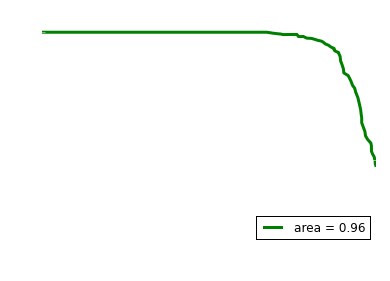

In [26]:
#The prediction performance of Tf-iDF and pattern of life in precision-recall curve

featuresList, text_model = featureExtraction(groups)
forest = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
classifer = plot_precision_recall(forest, featuresList)

526 Normal and 275 BPD in Training Data
59 Normal and 31 BPD in Test Data
Number of features: 4


/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


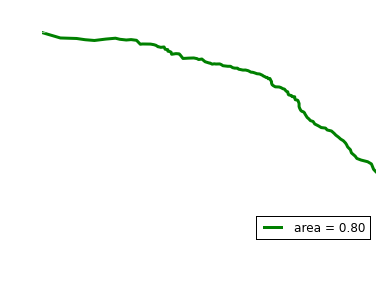

array([ 0.34043964,  0.2538975 ,  0.2391824 ,  0.16648046])

In [27]:
#The prediction performance of pattern of life in precision-recall curve

featuresList = featureExtraction(groups, text_extraction=False)
classifer = plot_precision_recall(forest, featuresList)
classifer.feature_importances_

526 Normal and 275 BPD in Training Data
59 Normal and 31 BPD in Test Data
Number of features: 3867906


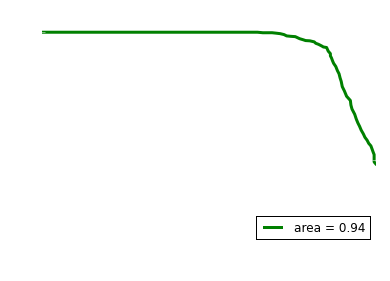

The following are the top 50 most important features:

bpd
borderline
thoughts
therapy
illness
health
self harm
personality disorder
recovery
disorder
therapist
bpdffs
bpdchat
game
feeling
mental health
help
effects
mental
today feeling
mentally
angry
stigma
relate
feeling bit
ward
sorry
cope
skills
lots
class
paranoia
feel
glass1ncision
urges
triggering
strong
senior
yall
come
feel better
guilt
help bpd
depressed
horrible
mindful
mh issues
school
nhs
exhaustion


In [29]:
#The prediction performance of Tf-iDF model in precision-recall curve and top-50 relevant n-grams

featuresList, text_model = featureExtraction(groups, polarity_extraction=False)
forest = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
classifer = plot_precision_recall(forest, featuresList)
try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))#[::-1]
    
showImportantFeatures(featureScores, text_model, n_features=50)



In [30]:
#The false-positive test of experts and therapists. 

coach_polarities = getUsersPolarities("coach_tweets_emotion")
coach_timeSeries = groupFilter(timeSeriesTransform(coach_polarities))
coach_feature, _ = getTextFeature([coach_timeSeries], text_model)
coach_X = coach_feature[0]
print(classifer.score(coach_X, np.zeros(coach_X.shape[0],dtype=int)))
classifer.predict(coach_X)

0.0833333333333


/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
forest = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=1024)
onlineFeatures = OnlineFeatureExtraction(groups)
classifer = plot_precision_recall(forest, onlineFeatures)

In [ ]:
joblib.dump(scalizor, '../5_interface/models/scaler/scaler') 

In [ ]:
onlineFeatures_scalized, scalizor = OnlineFeatureExtraction_scalized(groups)


In [ ]:
forest = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=1024)

classifer = plot_precision_recall(forest, onlineFeatures_scalized)

In [138]:
names = []
methods = [getEmotionRatio, getLIWC_feature,getJHFeature,getGBFeature,getAgeGenderFeature]
all_data, name = featureEtractionWrapper(methods, groups)
names.append('+'.join(name))
methods = [getEmotionRatio,getJHFeature,getGBFeature,getAgeGenderFeature]
emotion_data, name = featureEtractionWrapper(methods, groups)
names.append('+'.join(name))
methods = [getLIWC_feature,getJHFeature,getGBFeature,getAgeGenderFeature]
LIWC_data, name = featureEtractionWrapper(methods, groups)
names.append('+'.join(name))

/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


526 Normal and 275 BPD in Training Data
59 Normal and 31 BPD in Test Data


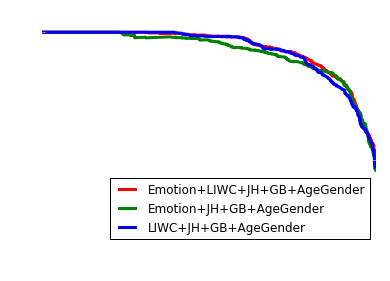

In [139]:
new_feature_lists = [all_data,emotion_data, LIWC_data]
plot_multiple_precision_recall(RandomForestClassifier(n_jobs=-1, n_estimators=1024),new_feature_lists,names)


In [140]:
names = []
methods = [getEmotionRatio, getLIWC_feature,getJHFeature,getGBFeature]
all_data, name = featureEtractionWrapper(methods, groups)
names.append('+'.join(name))
methods = [getEmotionRatio,getJHFeature,getGBFeature]
emotion_data, name = featureEtractionWrapper(methods, groups)
names.append('+'.join(name))
methods = [getLIWC_feature,getJHFeature,getGBFeature]
LIWC_data, name = featureEtractionWrapper(methods, groups)
names.append('+'.join(name))

/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


526 Normal and 275 BPD in Training Data
59 Normal and 31 BPD in Test Data


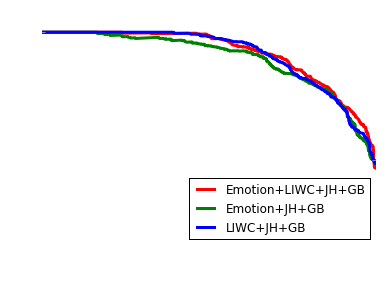

In [141]:
new_feature_lists = [all_data,emotion_data, LIWC_data]
plot_multiple_precision_recall(RandomForestClassifier(n_jobs=-1, n_estimators=1024),new_feature_lists,names)

526 Normal and 275 BPD in Training Data
59 Normal and 31 BPD in Test Data


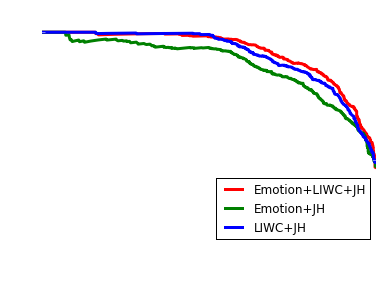

In [142]:
names = []
methods = [getEmotionRatio, getLIWC_feature,getJHFeature]
all_data, name = featureEtractionWrapper(methods, groups)
names.append('+'.join(name))
methods = [getEmotionRatio,getJHFeature]
emotion_data, name = featureEtractionWrapper(methods, groups)
names.append('+'.join(name))
methods = [getLIWC_feature,getJHFeature]
LIWC_data, name = featureEtractionWrapper(methods, groups)
names.append('+'.join(name))
new_feature_lists = [all_data,emotion_data, LIWC_data]
plot_multiple_precision_recall(RandomForestClassifier(n_jobs=-1, n_estimators=1024),new_feature_lists,names)

526 Normal and 275 BPD in Training Data
59 Normal and 31 BPD in Test Data


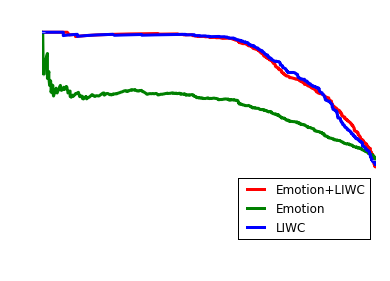

In [143]:
names = []
methods = [getEmotionRatio, getLIWC_feature]
all_data, name = featureEtractionWrapper(methods, groups)
names.append('+'.join(name))
methods = [getEmotionRatio]
emotion_data, name = featureEtractionWrapper(methods, groups)
names.append('+'.join(name))
methods = [getLIWC_feature]
LIWC_data, name = featureEtractionWrapper(methods, groups)
names.append('+'.join(name))
new_feature_lists = [all_data,emotion_data, LIWC_data]
plot_multiple_precision_recall(RandomForestClassifier(n_jobs=-1, n_estimators=1024),new_feature_lists,names)